# Packages 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, roc_curve, auc, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from numpy.random import seed
seed(1)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras import backend as K

# from kerastuner.tuners import RandomSearch

## Model

In [2]:
def eval_lstm_simple(X_train, Y_train, X_test, Y_test, time_steps, n_features, params):
  # Build the Model
  model = Sequential()
  model.add(LSTM(params['HL_1'], activation=tf.nn.relu, input_shape=(time_steps, n_features)))
  model.add(Dropout(params['drop1']))
  model.add(BatchNormalization())
#   model.add(Dense(10, activation = tf.nn.relu))
  model.add(Dense(1, activation = tf.nn.sigmoid))
    
#   opt = keras.optimizers.Adam(learning_rate=0.001)
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = params['patience'], verbose=1)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = 'nadam', metrics=['accuracy'])

  # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
  
  # Implement class weights
  cw = {
      0: params['w0'],
      1: params['w1']
  }
  model.summary()
  # Train the model
  history = model.fit(X_train, Y_train, epochs = params['epochs'], batch_size = params['batch'], class_weight=cw, callbacks=[callback])

#   # Predict on data
#   Y_pred = model.predict(X_test)
#   Y_pred = np.round(Y_pred, 0)
#   np.where(Y_pred == 1)
#   cm = confusion_matrix(Y_test, Y_pred)
#   print("CONFUSION MATRIX")
#   print(cm)
#   print("CLASSIFICATION REPORT")
#   print(classification_report(Y_test, Y_pred, target_names=["non_fall", "fall"]))
    
  return history, model

## ROC for subject wise CV

In [3]:
def roc_outer_cross_val(X, Y, params,lb,feature_count):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fold = 0
    groups = [1,2,3,4,5,6]
    split_model = LeaveOneGroupOut()
    for train_index, test_index in split_model.split(X, Y, groups):
        
        X_train = []
        Y_train = []

        for i in train_index:
            X_train.append(X[i])
            Y_train.append(Y[i])
            print("appending index: ",i,"length of X_train after appending : ",len(X_train))
        
        X_train = np.vstack(X_train)
        Y_train = np.vstack(Y_train)
        print("test_index is",test_index[0])
        X_test = X[test_index[0]]
        Y_test = Y[test_index[0]]
        
        print("Final X_train: ",X_train.shape)
        print("Final Y_train: ",Y_train.shape)
        
        history, model = eval_lstm_simple(X_train, Y_train, X_test, Y_test, lb, feature_count, params)        
        probas = model.predict(X_test)
        
        fpr, tpr, thresholds = roc_curve(Y_test, probas)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        fold += 1
    
    return tprs,mean_fpr,aucs

## ROC graph on moving window

In [5]:
features = {
    'mag' : ['accel_base_mag','fall_value'],
    'XYZ' : ['accel_base_X','accel_base_Y','accel_base_Z','fall_value'],
    'XYZ_mag' : ['accel_base_X','accel_base_Y','accel_base_Z','accel_base_mag','fall_value']
}

In [6]:

lb = 50
rem_range = 500
skip_val = 25
feat_type = "mag"
fall_buffer = 75
feature_count = len(features[feat_type])-1

# subjects = [S1, S2, S3, C1, C2, C3]
subject_names = ["S1", "S2", "S3", "C1", "C2", "C3"]

In [7]:
params = { # With Feature Scaling
    'drop1' : 0.2,
    'drop2': 0.2,
    'w1' : 750.,
    'w0' : 1.,
    'batch' : 7500,
    'epochs' : 2,
    'patience' : 5,
    'HL_1' : 15,
    'HL_2' : 5,
    'lr': 0.001,
}


## Collecting all TPR and FPR information

In [8]:
lead_times = [10,100,200,300,400,2000]
lead_times = [100]

auc_values = []
dict_tpr = dict()
dict_fpr = dict()
dict_auc = dict()

for lead_time in lead_times:
    X = []
    Y = []
    print("predicting on features for lead time:{} ms".format(lead_time))
    for sub in subject_names:
        temp_path = "../../../Features/Lead_Times/"+str(lead_time)+"ms/mag/"
        meta = "_" + str(feat_type) + "_" + str(lead_time) + "ms_" + str(lb) + "lb"
        temp_sub_X = "X_" + sub + meta + ".npy"
        temp_sub_Y = "Y_" + sub + meta + ".npy"
        
        temp_X = np.load(temp_path+ temp_sub_X).astype(np.float32)
        temp_Y = np.load(temp_path+ temp_sub_Y).astype(np.float32)
        
        X.append(temp_X)
        Y.append(temp_Y)
    
    tprs,mean_fpr,aucs = roc_outer_cross_val(X, Y, params,lb,feature_count)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    auc_values.append(round(mean_auc,3))
    std_auc = np.std(aucs)
    dict_tpr[lead_time] = mean_tpr
    dict_fpr[lead_time] = mean_fpr
    dict_auc[lead_time] = aucs

predicting on features for lead time:100 ms
appending index:  1 length of X_train after appending :  1
appending index:  2 length of X_train after appending :  2
appending index:  3 length of X_train after appending :  3
appending index:  4 length of X_train after appending :  4
appending index:  5 length of X_train after appending :  5
test_index is 0
Final X_train:  (225844, 50, 1)
Final Y_train:  (225844, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                1020      
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15)                60        
_________________________________________________________________
dense (Dense)                (None, 1

28/28 [==============================] - 11s 393ms/step - loss: 0.8370 - accuracy: 0.7853
Epoch 2/2
28/28 [==============================] - 12s 424ms/step - loss: 0.7327 - accuracy: 0.8451


## Ploting ROC curve and Calculating sensitivity with fixed specificity (0.99)

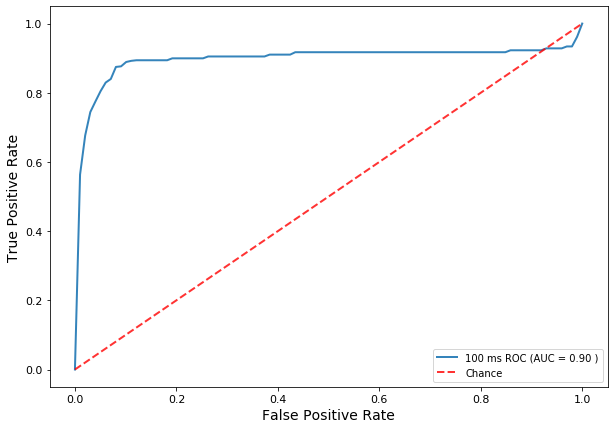

In [36]:
lead_times = [10,100,200,300,400,2000]
lead_times = [100]
auc_values = []

specificity = 0.97
tpr_tnr_table = pd.DataFrame(columns={'lead time(in ms)','sensitivity','specificity'})
plt.figure(figsize=(10,7))

for lead_time in lead_times:
    mean_tpr = dict_tpr[lead_time]
    mean_fpr = dict_fpr[lead_time]
    sensitivity = np.interp(1-specificity,mean_fpr,mean_tpr)
    tpr_tnr_table = tpr_tnr_table.append({'lead time(in ms)':lead_time,'sensitivity':round(sensitivity,3),'specificity':(specificity)},
                       ignore_index = True)

    aucs = dict_auc[lead_time] 
    mean_auc = auc(mean_fpr, mean_tpr)
    auc_values.append(round(mean_auc,3))
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr,
             label=str(index)+' ms ROC (AUC = %0.2f )' % (mean_auc),
             lw=2, alpha=.9)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
     label='Chance', alpha=.8) 

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.tick_params(labelsize=11)
plt.xlabel('False Positive Rate',fontsize = 14 )
plt.ylabel('True Positive Rate', fontsize = 14 )
plt.legend(loc="lower right")
img_name = 'ROC_curve'+' ms.png'
plt.savefig(img_name,bbox_inches='tight')
plt.show()

## Sensitivity with Specificity

In [37]:
tpr_tnr_table.head()

,specificity,lead time(in ms),sensitivity
0,0.97,100.0,0.742


In [38]:
# converting decimal to percentage 
tpr_tnr_table['sensitivity'] = tpr_tnr_table['sensitivity'].apply(lambda x : str(round(x*100,1))+" %") 
#converting float to int
tpr_tnr_table['lead time(in ms)'] = tpr_tnr_table['lead time(in ms)'].apply(lambda x : int(x)) 

tpr_tnr_table.head()

,specificity,lead time(in ms),sensitivity
0,0.97,100,74.2 %
